# Airline Sentiment Analysis

A sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

# Data:
- **Tweets.csv:**
    - tweet_id
    - airline_sentiment
    - airline_sentiment_confidence
    - negativereason
    - negativereason_confidence
    - airline
    - airline_sentiment_gold
    - name
    - negativereason_gold
    - retweet_count
    - text
    - tweet_coord
    - tweet_created
    - tweet_location
    - user_timezone

## Data Summary


In [25]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',None)
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer    
from nltk.corpus import stopwords   
stopwords = stopwords.words('english')
import re
import unicodedata
from bs4 import BeautifulSoup
import sys  
!python3 -m pip install contractions
import contractions
!python3 -m pip install pandarallel
from pandarallel import pandarallel
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

In [5]:
lemmatizer = WordNetLemmatizer()
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Loading data into pandas dataframe
data = pd.read_csv('./drive/MyDrive/Tweets.csv')

In [8]:
data.shape

(14640, 15)

In [9]:
data.info

<bound method DataFrame.info of                  tweet_id  ...               user_timezone
0      570306133677760513  ...  Eastern Time (US & Canada)
1      570301130888122368  ...  Pacific Time (US & Canada)
2      570301083672813571  ...  Central Time (US & Canada)
3      570301031407624196  ...  Pacific Time (US & Canada)
4      570300817074462722  ...  Pacific Time (US & Canada)
...                   ...  ...                         ...
14635  569587686496825344  ...                         NaN
14636  569587371693355008  ...                         NaN
14637  569587242672398336  ...                         NaN
14638  569587188687634433  ...  Eastern Time (US & Canada)
14639  569587140490866689  ...                         NaN

[14640 rows x 15 columns]>

In [10]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Data Columns


In [11]:
# negative: 0, neutral: 1, positive: 2
data['airline_sentiment'] = data['airline_sentiment'].astype('category').cat.codes
data['airline_sentiment'].value_counts(normalize=True,
                          dropna=False).sort_index()

0    0.626913
1    0.211680
2    0.161407
Name: airline_sentiment, dtype: float64

In [12]:
data.drop(columns=['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
         inplace=True)
data.head()

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials to the experience... tacky.
2,1,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,0,@VirginAmerica and it's a really big bad thing about it


In [13]:
data.shape

(14640, 2)

## Data Pre-Processing


In [14]:
def html_tags_remover(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
  
def tokenize(text):
    return nltk.word_tokenize(text)

def nums_remover(text):
    text = re.sub(r'\d+', '', text)
    return text

def contractions_fixer(text):
    return contractions.fix(text)

# remove from tokenized
def non_ascii_remover(words):
    clean = []
    for word in words:
        non_ascii_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        clean.append(non_ascii_word)
    return clean

# remove from tokenized
def punctuation_remover(words):
    clean = []
    for word in words:
        no_punct_word = re.sub(r'[^\w\s]', '', word)
        if no_punct_word != '':
            clean.append(no_punct_word)
    return clean

# remove from tokenized
def lowercase(words):
  clean = []
  for word in words:
      lowercase_word = word.lower()
      clean.append(lowercase_word)
  return clean

# remove from tokenized
def stopwords_remover(words):
    clean = []
    for word in words:
        if word not in stopwords:
            clean.append(word)
    return clean

def lemmatize(words):
    clean = []
    for word in words:
        clean.append(lemmatizer.lemmatize(word, pos='v'))
        
    return clean

In [15]:
def text_to_words(text):
  return tokenize(contractions_fixer(nums_remover(html_tags_remover(text))))

def process_words(words):
  words = lemmatize(stopwords_remover(punctuation_remover(lowercase(non_ascii_remover(words)))))
  # convert back to text string in the dataframe
  return ' '.join(words)

In [23]:
data['text'] = data.parallel_apply(lambda row: process_words(text_to_words(row['text'])), axis=1)

In [24]:
data.head()

,airline_sentiment,text
0,1,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience tacky
2,1,virginamerica today must mean need take another trip
3,0,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,0,virginamerica really big bad thing


In [29]:
negatives = '' 

for tweets in data[data['airline_sentiment']==0].text: 
    tokens = tweets.split() 
    negatives += " ".join(tokens) + " "
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(negatives) 

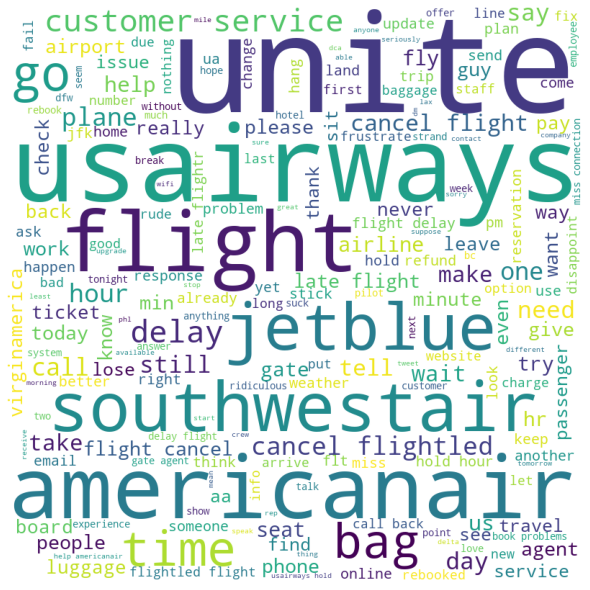

In [30]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

## Vectorization


In [ ]:
"""
a. Use CountVectorizer.
b. Use TfidfVectorizer.
"""

In [ ]:
"""
What to do after text pre-processing:
o Bag of words
o Tf-idf
"""

In [ ]:
# drop airline sentiment here for Y 
labels = data['airline_sentiment']
# drop in place true

## Modelling and Evaluation

In [ ]:
# Fit and evaluate model using BOTH type of vectorization.

In [ ]:
# Build the classification model. 

In [ ]:
# Evaluate the model.

## Conclusion

In [ ]:
"""
Summarize your understanding of the application of Various Pre-processing and Vectorization and
performance of your model on this dataset. 
"""